### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from sklearn.decomposition import PCA

### Functions

In [3]:
def cleanDescriptions(productDescriptions):
    '''Clean product descriptions
    Remove all unecessary characters and noise to the classification model
    '''

    product_descriptions = productDescriptions.str.lower()

    new_series = pd.Series()

    for row in product_descriptions:
        clean_row = " "+ row +" " # Add a space before and after description, to support following replacements
        clean_row = re.sub(r'\/', ' ', clean_row, 0, re.IGNORECASE) # Repace forward slash with a space
        clean_row = re.sub(r'[^a-z0-9\s\,\.]+', '', clean_row, 0, re.IGNORECASE) # Remove special characters
        clean_row = re.sub(r'([a-z]{1})([0-9]{1})','\g<1> \g<2>', clean_row, 0, re.IGNORECASE) # Separate Letters from Numbers
        clean_row = re.sub(r'([0-9]{1})([a-z]{1})','\g<1> \g<2>', clean_row, 0, re.IGNORECASE) # Separate Numbers from Letters
        clean_row = re.sub(r'(\d{1,3})\,(\d{3,})','\g<1>\g<2>', clean_row, 0, re.IGNORECASE) # Remove comma from large numbers
        clean_row = re.sub(r'(\d*)\.\d*', '\g<1>', clean_row, 0, re.IGNORECASE) # Remove decimal values
        clean_row = re.sub(r'\s[a-z]{1}\s', ' ', clean_row, 0, re.IGNORECASE) # Remove individual characters
        clean_row = re.sub(r'\s[0-9]{1}\s', ' ', clean_row, 0, re.IGNORECASE) # Remove individual characters
        clean_row = clean_row.strip() # Strip added spaces

        new_series = new_series.append(pd.Series([clean_row]),  ignore_index=True)
                
    return new_series.to_numpy()

### Import Dataset

In [4]:
# Import Cisco’s Public Export Product Data (PEPD)
raw_data = pd.read_csv("Cisco_raw_data.csv", encoding='cp1252')

c:\Users\GJ584JM\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### ETL

In [5]:
# Remove SERVICE Product Family
raw_data = raw_data.loc[raw_data['Product Family'] != "SERVICE"] 

# Keep only necessary fields
raw_data = raw_data[["Product Desc","US ECCN"]] 

# Check and drop nas
print(raw_data.isna().sum()) 
raw_data.dropna(axis=0, inplace=True)

 # Remove both the leading and the trailing white spaces 
raw_data['Product Desc'] = raw_data['Product Desc'].str.strip()

# Count number of words in each description and keep only descriptions with more than 5 words
raw_data['Number of words'] = raw_data['Product Desc'].apply(lambda desc : len(desc.split())) 
raw_data = raw_data.loc[raw_data['Number of words'] > 5] 

# Label predictors 
raw_data["Predictor"] = raw_data['US ECCN'].apply(lambda eccn : 0 if eccn == "EAR99" else 1) 
raw_data["Predictor Name"] = raw_data['US ECCN'].apply(lambda eccn : "Not Controlled" if eccn == "EAR99" else "Controlled")

# Drop unecessary fields
raw_data.drop(['US ECCN', 'Number of words'], axis=1, inplace=True) 

# Remove duplicates
df = raw_data.drop_duplicates()

Product Desc    12
US ECCN          8
dtype: int64


### Sampling Dataset

In [6]:
# Sampling and reducing significantly the data size to run tests faster before running the final model
#df = df.sample(n = 2000)

### Train Test Split

In [7]:
# Check predictors frequency
print(df["Predictor Name"].value_counts(normalize=True))

# BAG OF WORDS (BOW)
X = df['Product Desc']
y = df['Predictor']

# Create training and test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, stratify=y, random_state=7)

Controlled        0.5504
Not Controlled    0.4496
Name: Predictor Name, dtype: float64


### Creating the TF-IDF model

In [8]:
# Clean and Prep Train Descriptions
x_train_clean = cleanDescriptions(x_train)

# Fit the bag-of-words model
vector = TfidfVectorizer(decode_error='replace', encoding='utf-8', stop_words='english')
x_train_vector = vector.fit_transform(x_train_clean)

C:\Users\GJ584JM\AppData\Local\Temp/ipykernel_8356/589478376.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_series = pd.Series()


### Prep TF-IDF data for visualization

In [9]:
# Create a dense table of the TF-IDF
tfidf_table = pd.DataFrame(x_train_vector.todense())

# Rename column names to have the word names
rename_dict = {value: key for key, value in vector.vocabulary_.items()}
tfidf_table.rename(columns=rename_dict, inplace=True)

# Extract IDF
idf = vector.idf_
idf_table = pd.DataFrame(idf, index = vector.get_feature_names(), columns=["IDF"])

# Create a table with the labels
labels = pd.DataFrame(y_train.reset_index())
labels.rename(columns={"Predictor" : "Predictor Placeholder"}, inplace=True)
labels = labels.loc[:,labels.columns == 'Predictor Placeholder']

# Merge labels with main table and label words with controlled and/or not controlled
tfidf_table = tfidf_table.merge(labels, how='inner', left_index=True, right_index=True)
labels_table = tfidf_table.groupby(["Predictor Placeholder"]).max()
labels_table = labels_table.transpose()

# Create one table of controlled and not controlled labels
tables = []

lists = [["Not controlled", 0], ["Controlled", 1]]

for list in lists:
    # Create DataFrame
    table = pd.DataFrame(labels_table[list[1]][labels_table[list[1]] > 0.0])
    table["Label"] = list[0]
    table.rename(columns={list[1]: "Desc Weight"}, inplace=True)

    # Count word frequency
    count = tfidf_table[tfidf_table["Predictor Placeholder"] == list[1]]
    count_table = pd.DataFrame()
    count_table["Count"] = [count[column][count[column] > 0.0].count() for column in count.columns]
    count_table.rename(index=rename_dict, inplace=True)
    # Merge
    table = table.merge(count_table, how='inner', left_index=True, right_index=True)
    table = table.merge(idf_table, how='inner', left_index=True, right_index=True)

    tables.append(table)

### Plot most and least frequent words

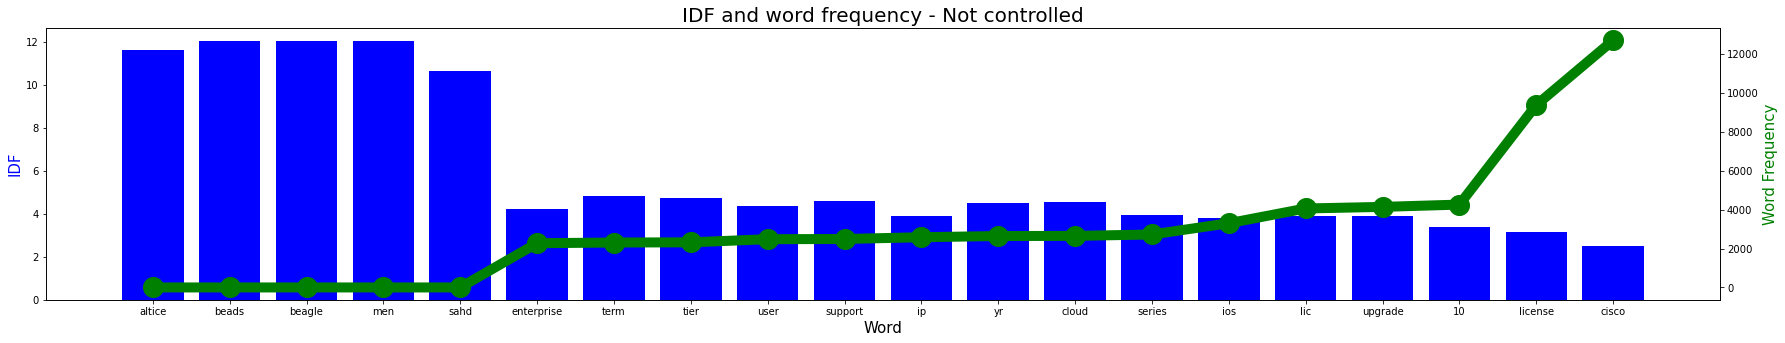

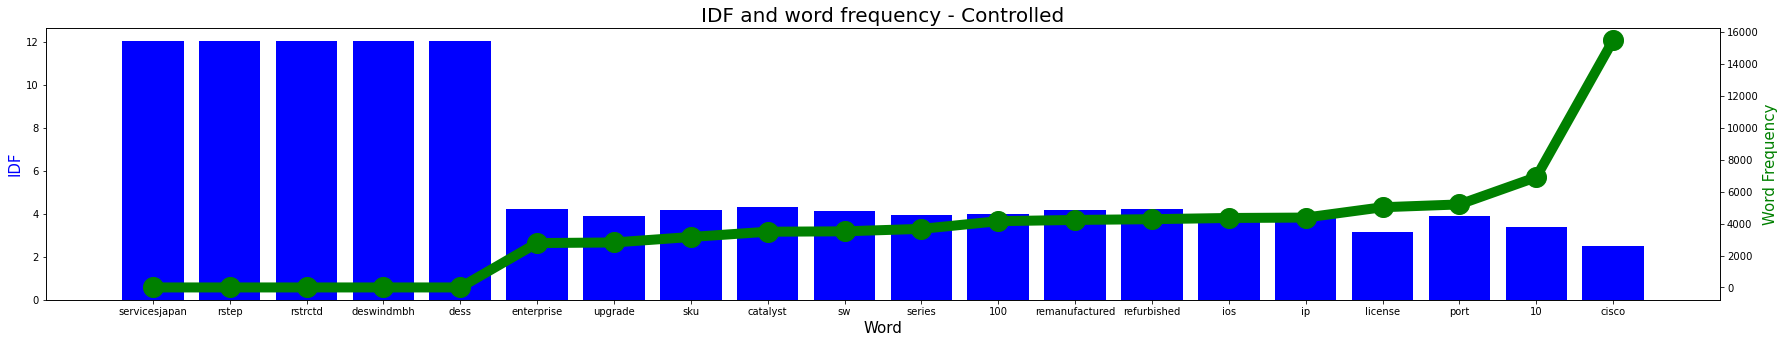

In [10]:
# For loop to plot both visuals
for tbl in tables:
    # Sort table
    table = tbl.sort_values(by='Count', ascending=True)

    # Keep top 10 and bottom 10 of each table
    table = pd.concat([table.head(), table.tail(15)])

    # Create figure and axis object
    fig,ax = plt.subplots(figsize=(30, 5))

    # Make first plot
    plt.bar(table.index,
            table["IDF"],
            label="IDF",
            color="blue")

    # set x and y-axis label
    ax.set_xlabel("Word",
                  fontsize = 15)

    ax.set_ylabel("IDF",
                color="blue",
                fontsize=15)

     # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()

    # make a plot with different y-axis using second axis object
    ax2.plot(table.index,
            table["Count"],
            label="Word Frequency",
            color="green",
            marker = "o",
            markersize = 20,
            linewidth= 10)

    ax2.set_ylabel("Word Frequency",
                    color="green",
                    fontsize=15)

    ax2.grid(False)

    plt.title("IDF and word frequency" + " - " + table["Label"].max(),
               fontsize = 20)
    plt.show()

### Identify Unique high frequency words

In [56]:
# Merge controlled and not controlled word frequency tables
merge_table = tables[0].merge(tables[1], how='outer', left_index=True, right_index=True)

# Look for No Controlled unique high frequency words, words that appear at leats 100 times and does not appear on Controlled descriptions
nc_tbl = merge_table[(merge_table["Count_x"] > 100) & (np.isnan(merge_table["Count_y"]) == True)]
print(40*"*",
     "\n",
     "No Controlled unique high frequency words",
     "\n",
     40*"*",
     "\n",
     nc_tbl["Count_x"])

# Look for Controlled unique high frequency words
c_tbl = merge_table[(merge_table["Count_y"] > 100) & (np.isnan(merge_table["Count_x"]) == True)]
print(40*"*",
     "\n",
     "Controlled unique high frequency words",
     "\n",
     40*"*",
     "\n",
     c_tbl["Count_y"])

**************************************** 
 No Controlled unique high frequency words 
 **************************************** 
 imagicle    150.0
like        147.0
qson        364.0
toll        182.0
wxss        841.0
Name: Count_x, dtype: float64
**************************************** 
 Controlled unique high frequency words 
 **************************************** 
 cnfg            206.0
compensation    113.0
ctrlrbased      113.0
expiration      138.0
fabrici         102.0
intersperse     131.0
nuee            140.0
oadm            248.0
regdomain       110.0
stackable       143.0
subr            139.0
teo             142.0
websense        106.0
Name: Count_y, dtype: float64


### Create model's instance and its Hyperameters list for GridSearch

In [11]:
### SVM
# Create an instance of SVM
model_1 = svm.SVC(random_state=7, probability=True)

## SVM Parameters
param_grid_1 = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.0001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
    "classifier" : [model_1]
    }
    
### Random Forest Classifier
# Create an instance of Random Forest classifier
model_2 = RandomForestClassifier(random_state=7)

## RF Parameters
param_grid_2 = {
    "classifier__max_depth": [50,200,600],
    "classifier__min_samples_split": [10, 25],
    "classifier__min_samples_leaf": [1, 15],
    "classifier__n_estimators": [30, 100],
    "classifier" : [model_2]
}

### Logistic Regression
# Create an instance of LogisticRegression classifier
model_3 = LogisticRegression(random_state=7)

## LG Parameters
param_grid_3 = {
    'classifier__penalty' : ['l2'],
    'classifier__max_iter' : [100,400,1000],
    'classifier__C' : [0.1,1,10],
    'classifier__solver' : ['lbfgs','liblinear','saga'],
    'classifier__multi_class' : ['ovr'],
    "classifier" : [model_3]
    }

# List of Parameters
params = [param_grid_1, param_grid_2, param_grid_3]

#Create the pipeline
pipe = Pipeline([('classifier', model_1)]) # model_1 is just a valid placeholder


### GridSearch

In [23]:
#Add all parameters to your model
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs=-1, scoring = 'f1')

# Fit your model on the grid
grid.fit(x_train_vector, y_train)

# Print the best model and model's Score and Best hyperparameters
print(grid.best_score_,"\n",grid.best_params_)

# Copying grid to clf, for replicability with saving/loading the best model is not necessary
clf = grid


0.9115526876954207 
 {'classifier': SVC(C=1, kernel='poly', probability=True, random_state=7), 'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


### Save and load best model

In [12]:
# Save model
joblib.dump(grid, 'best_model.joblib')

# Load model as clf for replicability
clf = joblib.load('best_model.joblib')

### Prep new/test data

In [13]:
# Clean and Prep Train Descriptions
x_test_clean = cleanDescriptions(x_test)

# Use same vector used before for the new descriptions
x_test_vector = vector.transform(x_test_clean)

C:\Users\GJ584JM\AppData\Local\Temp/ipykernel_8356/589478376.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_series = pd.Series()


### Classification

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     13923
           1       0.91      0.93      0.92     17044

    accuracy                           0.91     30967
   macro avg       0.91      0.91      0.91     30967
weighted avg       0.91      0.91      0.91     30967



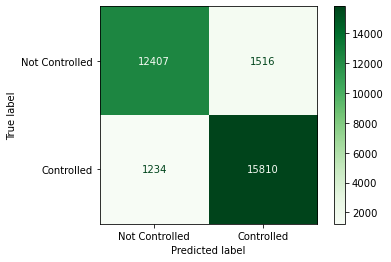

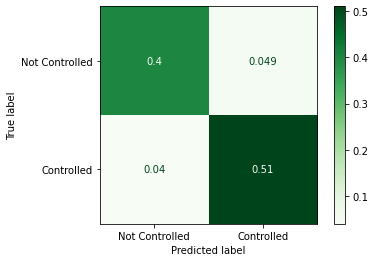

In [14]:
# Create the predictions
y_pred = clf.predict(x_test_vector)

# Classification Report
print(classification_report(y_test, y_pred))

# Create and visualize the confusion matrix
# Display values
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Not Controlled","Controlled"])
display_cm.plot(cmap= plt.cm.Greens)

# Display percentages
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='all')
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Not Controlled","Controlled"])
display_cm.plot(cmap= plt.cm.Greens)

### Output results

In [15]:
## Create DataFrame with new descriptions and predictions
new_df = pd.DataFrame()
new_df['Description'] = x_test
new_df['Description Length'] = new_df['Description'].apply(lambda desc : len(desc.split())) 
new_df['Known Label'] = y_test
new_df['Known Label Name'] = ["Controlled" if i == 1 else "Not Controlled" for i in new_df['Known Label']]
new_df["Prediction Label"] = y_pred
new_df["Prediction Label Name"] = ["Controlled" if i == 1 else "Not Controlled" for i in new_df["Prediction Label"]]
new_df["Correct Prediction"] = new_df["Prediction Label"] == new_df["Known Label"]

# Outpub model confidence score
probs = clf.predict_proba(x_test_vector)
new_df["Score"] = np.max(probs, axis=1)

# Ouput to .csv
new_df.to_csv("Model Outcome.csv", encoding='utf8')

### Machine Learning Output Analysis

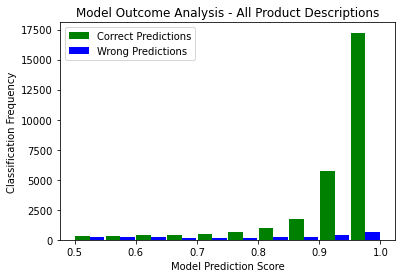

In [19]:
# Create Series with correct and wrong predictions
t_pred = new_df[new_df["Correct Prediction"] == True]["Score"]
f_pred = new_df[new_df["Correct Prediction"] == False]["Score"]

#print(len(t_pred), len(f_pred))

# Histogram to check classification's frequency
plt.hist([t_pred,f_pred],
        bins=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
        rwidth=0.95,
        color=['green','blue'],
        label=['Correct Predictions', 'Wrong Predictions'],
        orientation='vertical')

plt.xlabel('Model Prediction Score')
plt.ylabel('Classification Frequency')
plt.title('Model Outcome Analysis - All Product Descriptions')
plt.legend()

### Analysis by number of words

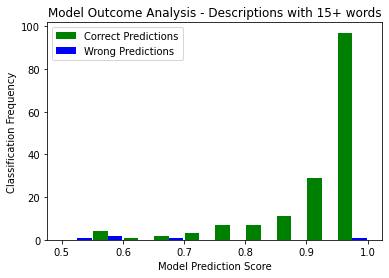

In [20]:
# Create Series with correct and wrong predictions, filtering out short descriptions
t_pred = new_df[(new_df["Correct Prediction"] == True)  & (new_df["Description Length"] > 14)]["Score"]
f_pred = new_df[(new_df["Correct Prediction"] == False) & (new_df["Description Length"] > 14)]["Score"]

#print(len(t_pred), len(f_pred))

# Histogram to check classification's frequency
plt.hist([t_pred,f_pred],
        bins=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
        rwidth=0.95,
        color=['green','blue'],
        label=['Correct Predictions', 'Wrong Predictions'],
        orientation='vertical')

plt.xlabel('Model Prediction Score')
plt.ylabel('Classification Frequency')
plt.title('Model Outcome Analysis - Descriptions with 15+ words')
plt.legend()

### Visualize Test data text classification clusters

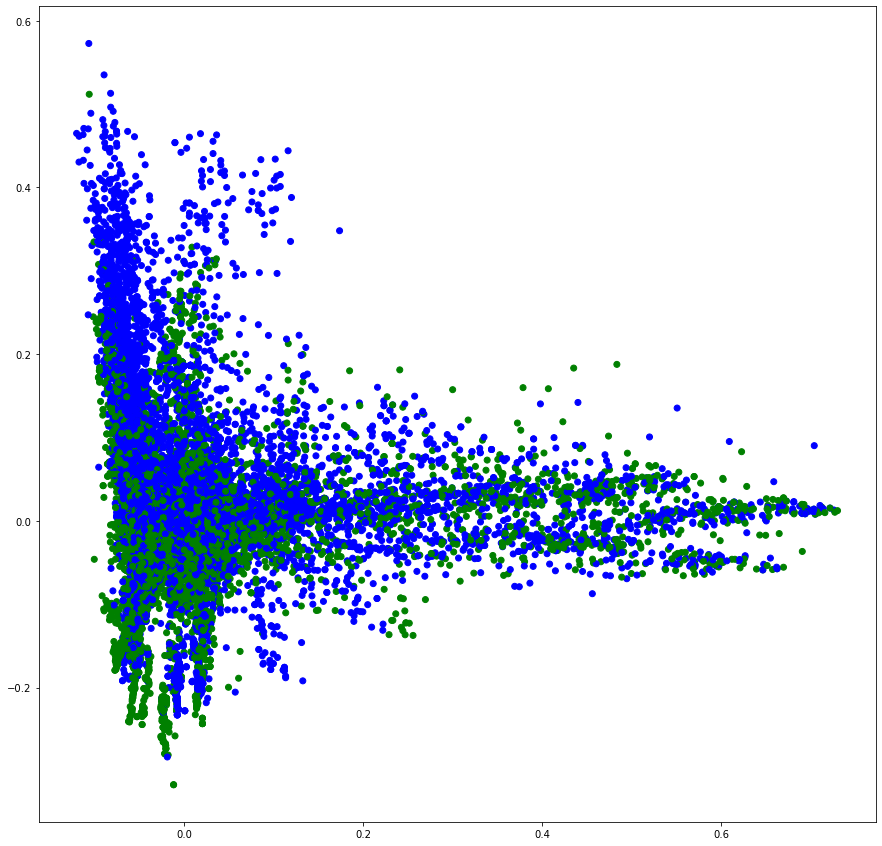

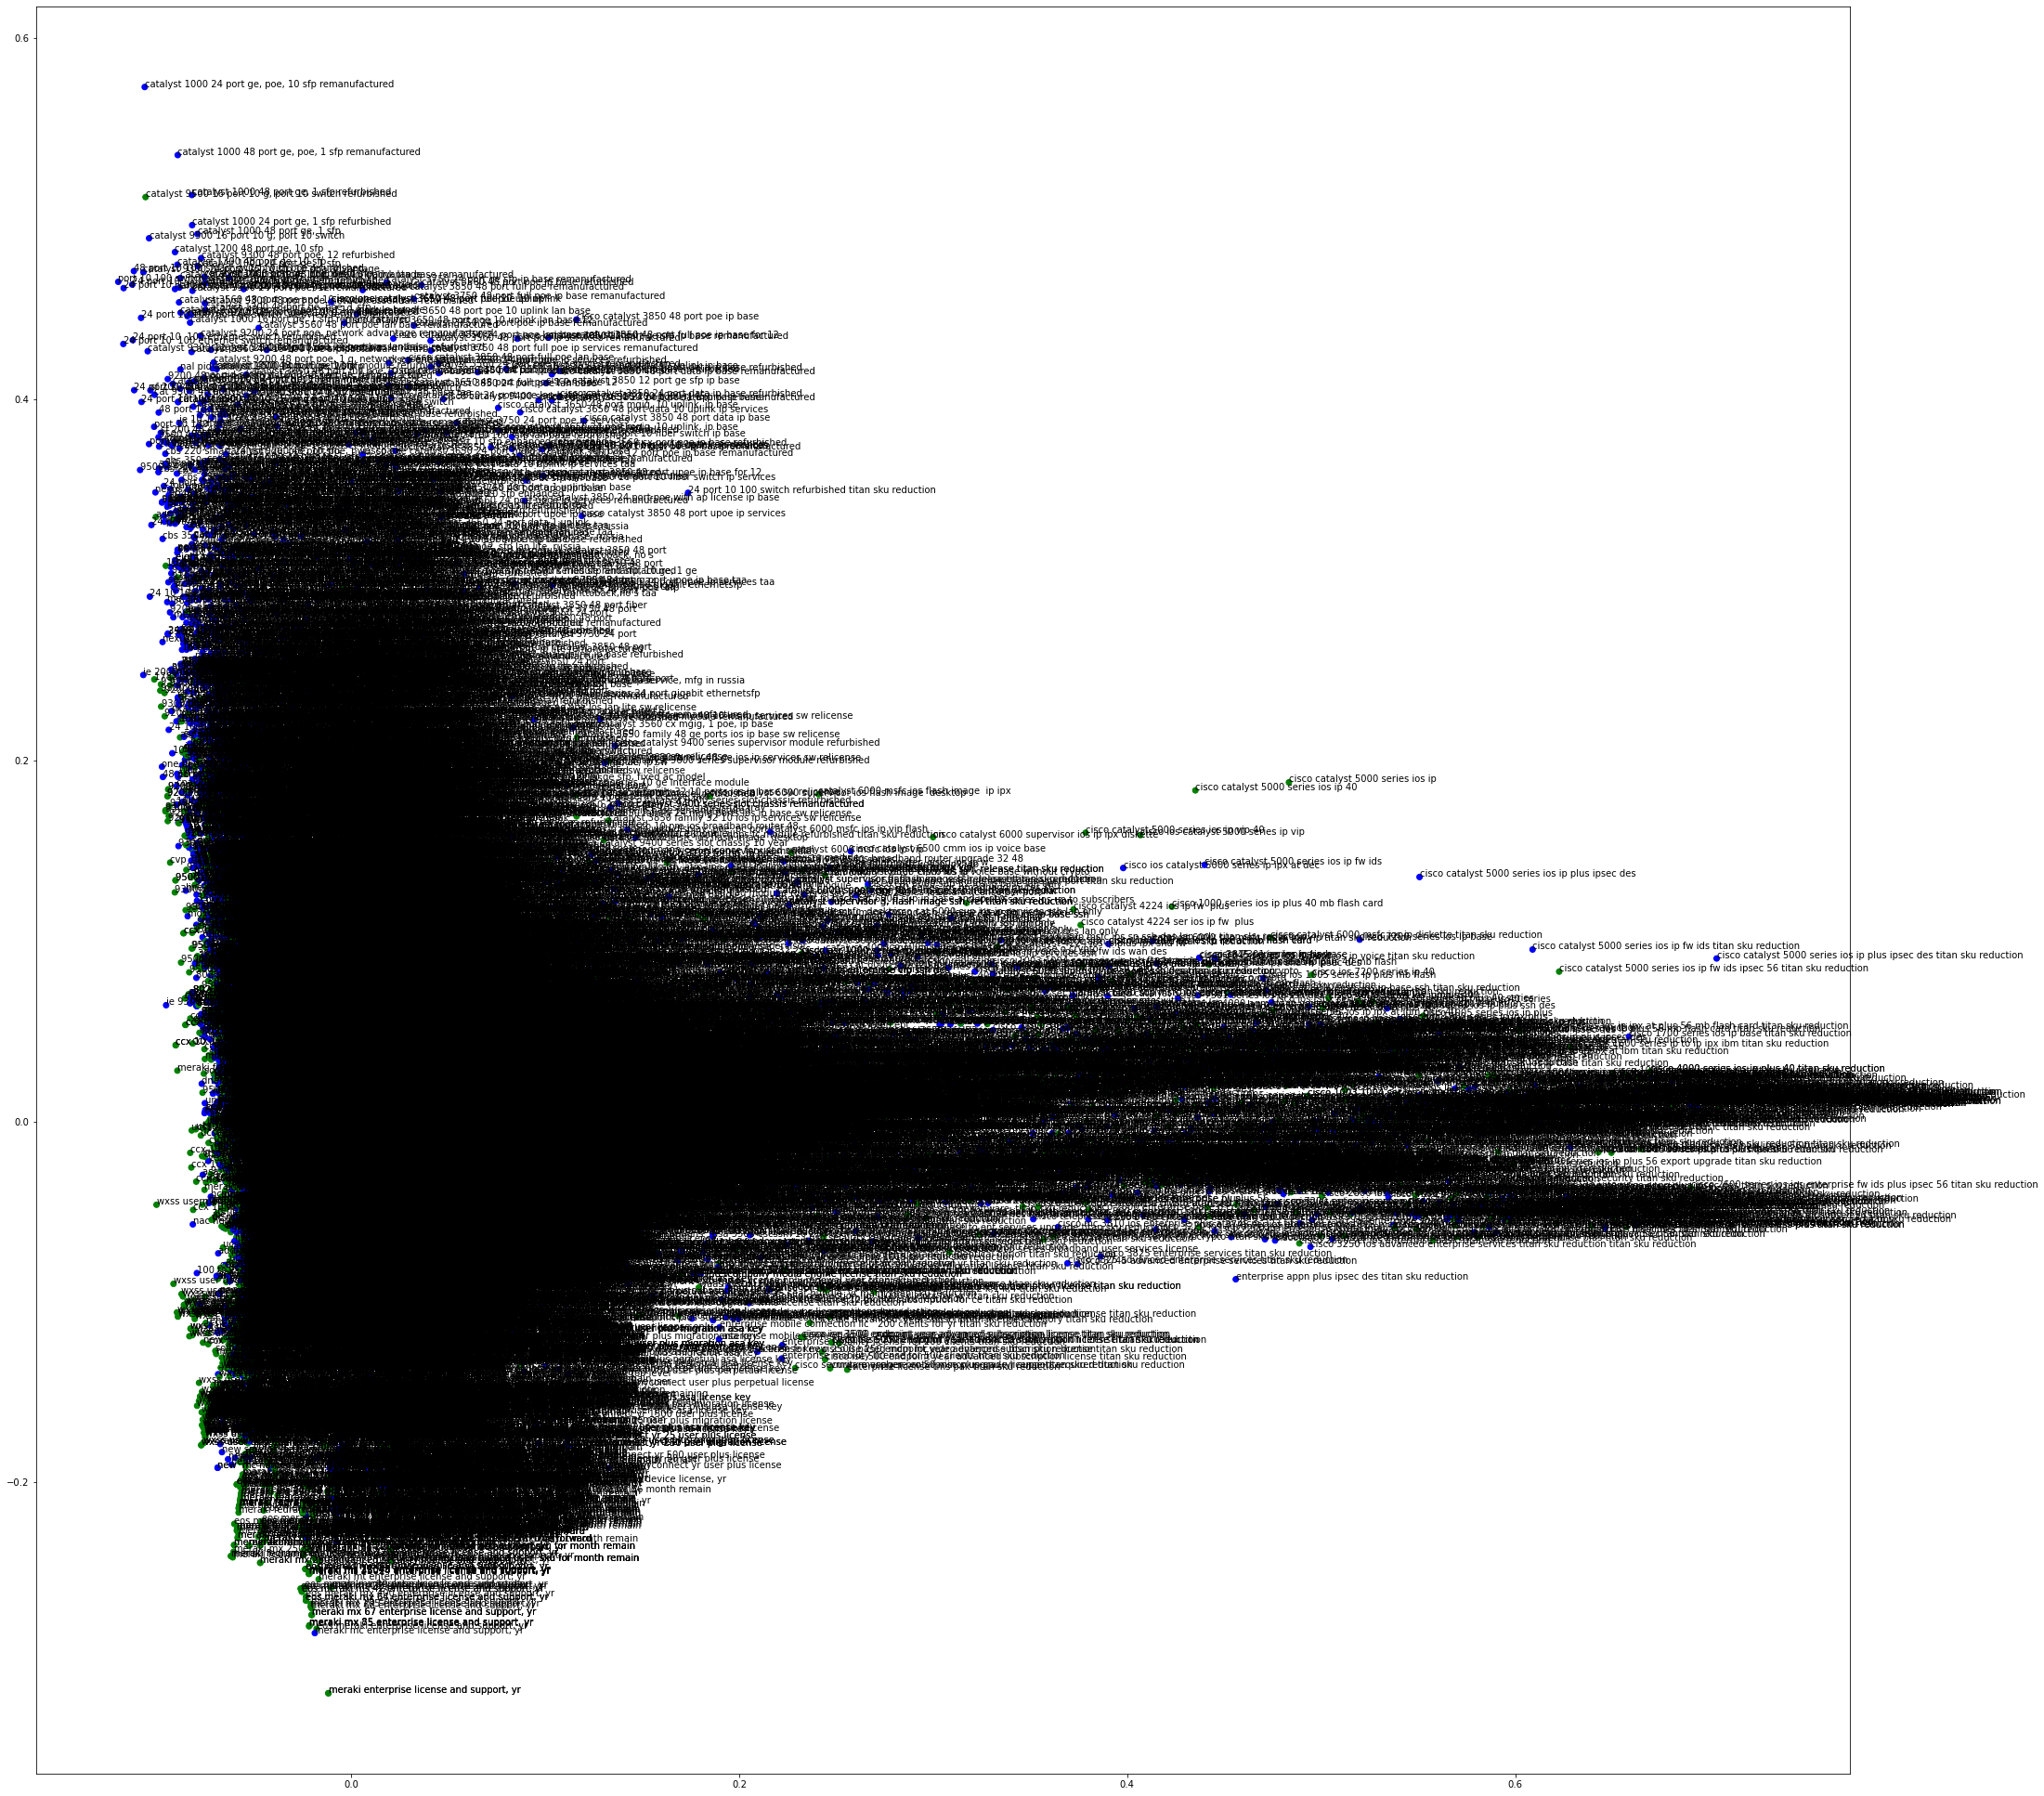

In [21]:
features = []
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(x_test_vector.toarray())
colors = ['green','blue']

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in y_test])
plt.show()

fig, ax = plt.subplots(figsize=(35,35))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in y_test])

for i, txt in enumerate(x_test_clean):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

plt.show()